In [1]:
import torch
import torchvision
import numpy as np
from typing import List, Tuple, Dict, Optional
import os
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import Image as IPythonImage
%matplotlib inline
from PIL import Image
from itertools import islice

## Pytorch's Computer Graph

### Update gradients directly by Tensors
  + Pytorch automatically calculates the gradient based on the loss function
  + you can either update weights from gradient mannually or by an optimizer
  + we can confirm the calculation of gradients by chain rule calculations

In [2]:
# initialize w and b and construct graph using function to link w and b to z
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True) 

x = torch.tensor([1.4])
y = torch.tensor([2.1])


z = w * x + b
 
loss = (y-z).pow(2).sum()
loss.backward()

print('dL/dw : ', w.grad)
print('dL/db : ', b.grad)

# confirm by chain rule calculation
print(2 * x * ((w * x + b) - y))


dL/dw :  tensor(-0.5600)
dL/db :  tensor(-0.4000)
tensor([-0.5600], grad_fn=<MulBackward0>)


## Building neural network models 
### building network layers by Pytorch

In [3]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU()
)

model

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

#### Configuring layers
 * Initializers `nn.init`: https://pytorch.org/docs/stable/nn.init.html 
 * L1 Regularizers `nn.L1Loss`: https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss
 * L2 Regularizers `weight_decay`: https://pytorch.org/docs/stable/optim.html
 * Activations: https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity  

In [4]:
# initialize a tensor using nn.init_xavier_uniform_
nn.init.xavier_uniform_(model[0].weight)
 
l1_weight = 0.01
l1_penalty = l1_weight * model[2].weight.abs().sum()
print(l1_penalty)

tensor(0.6208, grad_fn=<MulBackward0>)


#### Compiling a model

 * Optimizers `torch.optim`:  https://pytorch.org/docs/stable/optim.html#algorithms
 * Loss Functions `tf.keras.losses`: https://pytorch.org/docs/stable/nn.html#loss-functions

In [5]:
# define loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

### Generate Dataset for training and validation
* construct a complex XOR dataset where feature matrix consists of two features comply to unifrom distribution in \[-1, 1\]
* if X\[0\] times X\[1\] > 0, y = 0. Otherwise y = 1
* this consists of a nonlinear separable dataset
* we use a linear NN model with a single layer and another nonliear NN model with multiple layers to predict y from x
* we then draw the plot and evaluate the results based on accuracy and loss on validation dataset
* to generate tensors, we can use torch.tensor with numpy array as the input, we can also using torch.from_numpy() function
  + torch.tensor is easier and allow us to directly define the datatype while from_numpy generate tensors as float64 and then we need to convert them to float 32

#### Generate dataset as tensors

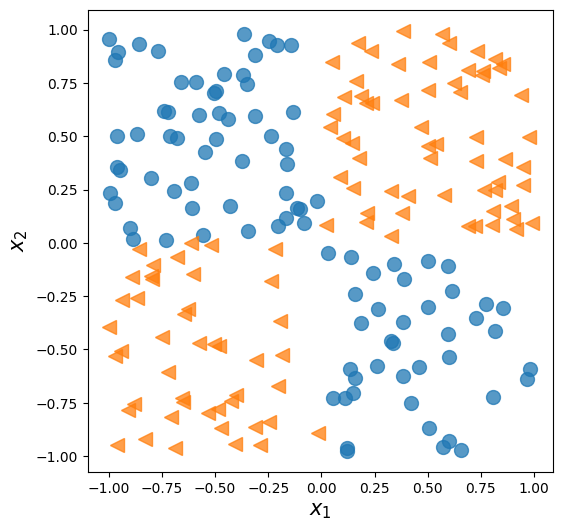

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


np.random.seed(1)
torch.manual_seed(1)
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0

n_train = 100

#
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)

fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], 
         x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], 
         x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)

#plt.savefig('figures/13_02.png', dpi=300)
plt.show()

#### Build tensor dataset and dataloader
* you can use either Dataset or TensorDataset. The advantages of TensorDataset is that you don't need to define the three internal methods as in Dataset
* Dataset, however, provides more flexibilities

In [7]:
from torch.utils.data import TensorDataset, DataLoader

In [8]:
batch_size = 2
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)

### Define general purpose model training and plot functions

#### Define a general purpose train method
* the train method defines the model, number of epochs, learning rate, data loader and validation dataset
* the train method uses SGD as the optimizer, and returns the loss history and accuracy history data for each epoch

In [9]:
def train(model, num_epochs, learning_rate, train_dl, x_valid, y_valid):
    torch.manual_seed(1)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        # convert to loss and accuracy averaged on each sample
        loss_hist_train[epoch] /= n_train/batch_size
        accuracy_hist_train[epoch] /= n_train/batch_size

        # already based on sample average values
        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid



#### Define plot function to plot training and validation loss and accuracy vs epochs
* the function accepts the loss_hist_train, loss_hist_valid, accuracy_train and accuracy_valid lists and draw the plots

In [10]:
from mlxtend.plotting import plot_decision_regions

def plot_curves(hist, model, x_valid, y_valid, draw_boundary=False):
    fig = plt.figure(figsize=(16, 4))
    if draw_boundary:
        ax = fig.add_subplot(1, 3, 1)
    else:
        ax = fig.add_subplot(1, 2, 1)
    plt.plot(history[0], lw=4)
    plt.plot(history[1], lw=4)
    plt.legend(['Train loss', 'Validation loss'], fontsize=15)
    ax.set_xlabel('Epochs', size=15)
    
    if draw_boundary:
        ax = fig.add_subplot(1, 3, 2)
    else:
        ax = fig.add_subplot(1, 2, 2)
    
    plt.plot(history[2], lw=4)
    plt.plot(history[3], lw=4)
    plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
    ax.set_xlabel('Epochs', size=15)

    if draw_boundary:
        ax = fig.add_subplot(1, 3, 3)
        plot_decision_regions(X=x_valid.numpy(), 
                          y=y_valid.numpy().astype(np.int64),
                          clf=model)
        ax.set_xlabel(r'$x_1$', size=15)
        ax.xaxis.set_label_coords(1, -0.025)
        ax.set_ylabel(r'$x_2$', size=15)
        ax.yaxis.set_label_coords(-0.025, 1)

### Build a simple linear model with one linear layer and a sigmoid activation
#### Define model architecture

In [12]:
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

model


Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

#### Train model

In [13]:
num_epochs = 300
history = train(model, num_epochs, 0.001, train_dl, x_valid, y_valid)

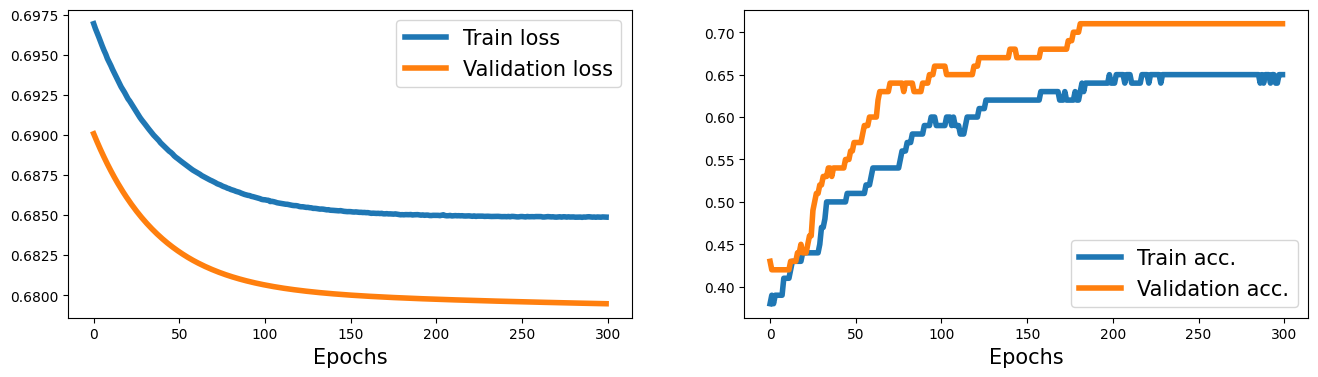

In [14]:
plot_curves(history, model, x_valid, y_valid)

### Build a more complex model using nn.Module
#### Define model architecture
* nn.module allows to build models with more flexibility
* we can translate nn.Sequential to nn.module using nn.ModulelList

In [15]:
class MultiLayerModel(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4, 1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)

    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()
            
model = MultiLayerModel()
model


MultiLayerModel(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

#### Train model

In [16]:
num_epochs = 300
history = train(model, num_epochs, 0.015, train_dl, x_valid, y_valid)

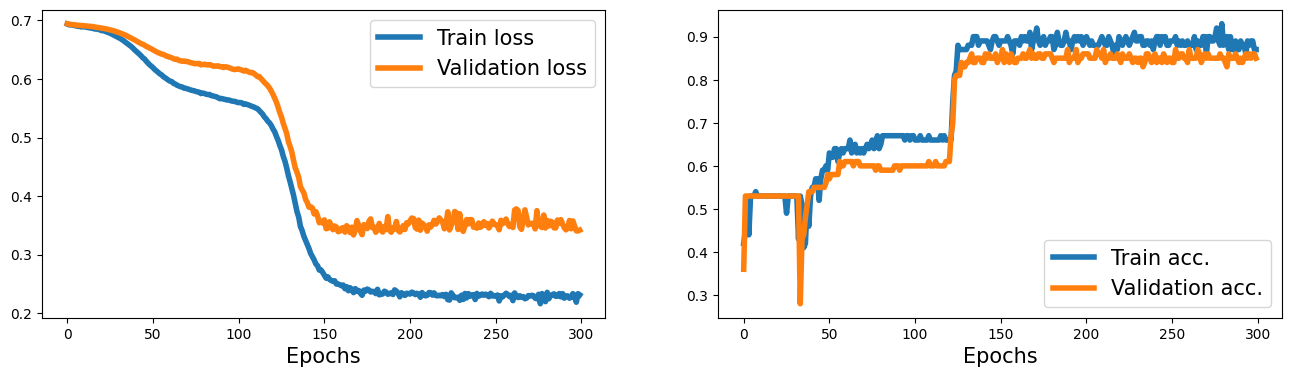

In [17]:
plot_curves(history, model, x_valid, y_valid)

## Project 1: predicting the fuel efficiency of a car
* predict MPG using other columns
  + numeric columns
  + categorical columns (one hot encoding)
  + discrete year column to 4 buckets

### Read dataset from url

In [18]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv(url, names=column_names,
                 na_values = "?", comment='\t',
                 sep=" ", skipinitialspace=True)

df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [19]:
print(df.isna().sum())

df = df.dropna()
df = df.reset_index(drop=True)
df.tail()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
387,27.0,4,140.0,86.0,2790.0,15.6,82,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,2
389,32.0,4,135.0,84.0,2295.0,11.6,82,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,1
391,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Prepare features
* split dataset to train and test
* numerical columns include \['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration'\]
* categorical columns include \['Model Year', 'Origin' \]
* discrete 'Model Year' based on the break points of \[73, 76, 79 \]

#### split dataset to train/test splits

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn

X, y = df.iloc[:, 1:], df.iloc[:, 0]
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 1)

#### standardize scaling and converting numeric columns to tensors

In [21]:
numeric_column_names = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration']
standard_scaler = StandardScaler()

x_train_numeric = x_train[numeric_column_names]
x_train_numeric_norm = standard_scaler.fit_transform(x_train_numeric)
x_test_numeric_norm = standard_scaler.transform(x_test[numeric_column_names])
x_train_numeric_tensor, x_test_numeric_tensor = torch.tensor(x_train_numeric_norm).float(), torch.tensor(x_test_numeric_norm).float()

In [22]:
x_train_numeric_tensor[:5]

tensor([[-0.8256, -0.5318, -0.5000, -0.5562, -0.0016],
        [ 0.3517,  0.3462,  0.1868,  0.7776,  1.1009],
        [-0.8256, -0.8927, -0.5264, -0.8760,  0.2924],
        [-0.8256, -1.0098, -1.0019, -1.1121,  0.2556],
        [-0.8256, -0.8244, -0.7642, -0.9102, -0.5529]])

#### discretize year to 4 buckets and encode to tensors

In [23]:
year_boundaries = torch.tensor([73, 76, 79])
x_train_model_year = torch.bucketize(torch.tensor(x_train['Model Year'].values), year_boundaries, right=True).float() 
x_test_model_year = torch.bucketize(torch.tensor(x_test['Model Year'].values), year_boundaries, right=True).float() 

In [24]:
x_train_model_year.dtype

torch.float32

#### encode Origin column using one hot encoding
* first factorize or using label encoding to convert Origin to numbers from 0 to number of classes - 1
* use one_hot function to convert Origin column to one hot columns

In [25]:
from torch.nn.functional import one_hot
x_train_origin_labels, unique_origin = pd.factorize(x_train['Origin'])
x_test_origin_labels, unique_origin = pd.factorize(x_test['Origin'])

num_classes = len(x_train['Origin'].unique())
x_train_origin = one_hot(torch.tensor(x_train_origin_labels), num_classes).float() 
x_test_origin = one_hot(torch.tensor(x_test_origin_labels), num_classes).float()

In [26]:
x_train_origin.dtype

torch.float32

In [27]:
y_train.shape

(313,)

In [28]:
y_test.shape

(79,)

#### Concatenate all columns to one tensor for train and test datasets

In [29]:
x_train_numeric_tensor.shape

torch.Size([313, 5])

In [30]:
x_train_model_year.shape

torch.Size([313])

In [31]:
x_train_origin.shape

torch.Size([313, 3])

In [32]:
x_train_tensor = torch.cat([x_train_numeric_tensor, x_train_model_year.reshape(-1, 1), x_train_origin], dim=1)
x_test_tensor = torch.cat([x_test_numeric_tensor, x_test_model_year.reshape(-1, 1), x_test_origin], dim=1)

In [33]:
x_train_tensor.shape

torch.Size([313, 9])

In [34]:
x_test_tensor.shape

torch.Size([79, 9])

In [35]:
y_train_tensor = torch.tensor(y_train.values).float()
y_test_tensor = torch.tensor(y_test.values).float()

In [36]:
y_train_tensor.shape

torch.Size([313])

### Build data loader

In [37]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(x_train_tensor, y_train_tensor)
torch.manual_seed(1)
batch_size = 8
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True)

### Build model
* build a 4 layer neural network using nn.sequential for regression

In [38]:
import torch.nn as nn

hidden_units = [8, 4]
input_size = x_train_tensor.shape[1]

all_layers = []

for hidden_unit in hidden_units:
    all_layers.append(nn.Linear(input_size, hidden_unit))
    all_layers.append(nn.ReLU())
    input_size = hidden_unit

all_layers.append(nn.Linear(hidden_units[-1], 1))

model = nn.Sequential(*all_layers)                  
model                  

Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

In [39]:
torch.manual_seed(1)
num_epochs = 200
log_epochs = 20 
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_train_hist = [0] * num_epochs
loss_test_hist = [0] * num_epochs

for epoch in range(num_epochs):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        batch_size = x_batch.shape[0]
        optimizer.zero_grad()
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        loss_train_hist[epoch] += loss.item() 
        loss_hist_train += loss.item()

    if epoch % 20 == 0:
        print(f'Epoch {epoch}  Loss {loss_hist_train/len(train_dl):.4f}')
    loss_train_hist[epoch] /= len(train_dl)   
    pred_valid = model(x_test_tensor)[:, 0]
    loss_valid = loss_fn(pred_valid, y_test_tensor)
    loss_test_hist[epoch] += loss_valid.item()

Epoch 0  Loss 526.2825
Epoch 20  Loss 8.4780
Epoch 40  Loss 7.7123
Epoch 60  Loss 7.4331
Epoch 80  Loss 7.0582
Epoch 100  Loss 6.9860
Epoch 120  Loss 6.5825
Epoch 140  Loss 6.8720
Epoch 160  Loss 7.3932
Epoch 180  Loss 6.5016


In [40]:
def plot_curves(train_hist, test_hist):
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(1, 2, 1)
    plt.plot(train_hist, lw=4)
    plt.plot(test_hist, lw=4)
    plt.legend(['Train loss', 'Validation loss'], fontsize=15)
    ax.set_xlabel('Epochs', size=15)

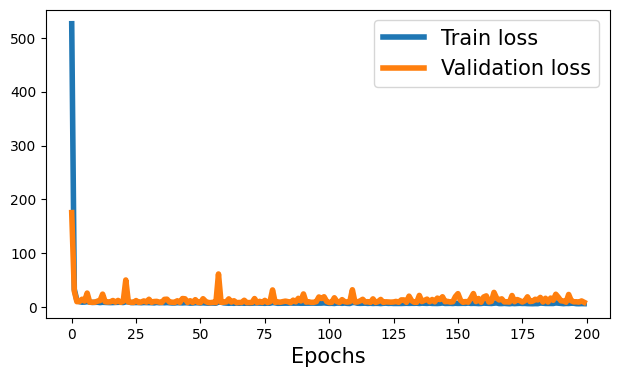

In [41]:
plot_curves(loss_train_hist, loss_test_hist)

## Project two - classifying MNIST hand-written digits
* using MNIST dataset to classify hand writing digits

### Prepare dataset

In [43]:
import torchvision 
from torchvision import transforms 


image_path = '../data'
transform = transforms.Compose([transforms.ToTensor()])

mnist_train_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=True, 
                                           transform=transform, 
                                           download=False)
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=False, 
                                           transform=transform, 
                                           download=False)
 
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)

### Build model

In [44]:
import torch.nn as nn

hidden_units = [32, 16]
image_size = mnist_train_dataset[0][0].shape
input_size = image_size[0] * image_size[1] * image_size[2]

all_layers = [nn.Flatten()]

for hidden_unit in hidden_units:
    all_layers.append(nn.Linear(input_size, hidden_unit))
    all_layers.append(nn.ReLU())
    input_size = hidden_unit

all_layers.append(nn.Linear(hidden_units[-1], 10))

model = nn.Sequential(*all_layers)

model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=32, bias=True)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=16, bias=True)
  (4): ReLU()
  (5): Linear(in_features=16, out_features=10, bias=True)
)

In [45]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_nums = 20

for epoch in range(epoch_nums):
    accuracy_hist = 0
    for batch_x, batch_y in train_dl:
        optimizer.zero_grad()

        pred = model(batch_x)
        loss = loss_fn(pred, batch_y)
        loss.backward()

        optimizer.step()
        accuracy_hist += (torch.argmax(pred, dim=1) == batch_y).float().sum()
    accuracy_hist /= len(train_dl.dataset)
    print(f"accuracy of epoch {epoch} is {accuracy_hist:.4f}") 
        

accuracy of epoch 0 is 0.8514
accuracy of epoch 1 is 0.9287
accuracy of epoch 2 is 0.9422
accuracy of epoch 3 is 0.9492
accuracy of epoch 4 is 0.9538
accuracy of epoch 5 is 0.9584
accuracy of epoch 6 is 0.9622
accuracy of epoch 7 is 0.9647
accuracy of epoch 8 is 0.9673
accuracy of epoch 9 is 0.9688
accuracy of epoch 10 is 0.9710
accuracy of epoch 11 is 0.9720
accuracy of epoch 12 is 0.9737
accuracy of epoch 13 is 0.9750
accuracy of epoch 14 is 0.9769
accuracy of epoch 15 is 0.9780
accuracy of epoch 16 is 0.9788
accuracy of epoch 17 is 0.9799
accuracy of epoch 18 is 0.9813
accuracy of epoch 19 is 0.9816


In [46]:
pred = model(mnist_test_dataset.data / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}') 

Test accuracy: 0.9646
